# CNN architectures

In [1]:
import time
import os
from glob import glob

import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from PIL import Image
import PIL
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms, datasets
torch.set_printoptions(precision=4, linewidth=100)

## Data setup

In [3]:
%cd data/fish
%cd train
%mkdir ../valid

/home/ec2-user/projects/fast_ai/data/fish
/home/ec2-user/projects/fast_ai/data/fish/train


In [10]:
g = glob('*')
for d in g: os.mkdir('../valid/'+d)

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
# 500ファイルをvalidに移動
for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

In [11]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [13]:
from shutil import copyfile

g = glob('*')
for d in g: 
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [15]:
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
# sampleにファイルをコピー
for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])

%cd ..

/home/ec2-user/projects/fast_ai/data/fish/valid
/home/ec2-user/projects/fast_ai/data/fish


In [16]:
%mkdir results
%mkdir sample/results
%cd ../..

/home/ec2-user/projects/fast_ai


### one-hot vector の作成

In [7]:
batch_size = 32
nb_digits = 10
y = torch.LongTensor(batch_size,1).random_() % nb_digits
# One hot encoding buffer that you create out of the loop and just keep reusing
y_onehot = torch.FloatTensor(batch_size, nb_digits)

# In your for loop
y_onehot.zero_()
# scatter_(dim, index, src) dim次元目のindexをsrcの値にする
y_onehot.scatter_(1, y, 1) # y_onehot[i][y[i]] = 1 になる


    1     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     1
    0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     0     0     0     1     0
    0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     1
    0     0     0     0     0     0     1     0     0     0
    0     0     0     0     1     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0
    1     0     0     0     0     0     0     0     0     0
    0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     1     0     0     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     1     0     0     0     0
    0     1     0     0     0     0    

## Precompute convolutional outputの取得

VGG16をfinetunedして、そのconv layerの出力を以降入力として用いる

In [435]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [436]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}

path = "data/fish/"
batch_size = 32 # バッチサイズが大きいとGPUのメモリに乗らないので注意
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
print(dataset_sizes, class_names)
use_gpu = torch.cuda.is_available()
print(use_gpu)

{'train': 3277, 'valid': 500} ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
True


In [437]:
# 置き換える層以外は再学習しないようにする
for param in vgg16.parameters():
    param.requires_grad = False

In [438]:
num_features = vgg16.classifier[6].in_features
modules = list(vgg16.classifier.children())
modules.pop()
modules.append(torch.nn.Linear(num_features, 8)) # ラベル数は8
new_classifier = torch.nn.Sequential(*modules)
vgg16.classifier = new_classifier

In [445]:
def train_model_normal(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] # loss.dataはsize 1 のTensorなので[0]を取る
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            # 最も良いモデルの重みを変数に保持
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [440]:
if use_gpu:
    vgg16 = vgg16.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9) # requires_grad=Falseのパラメーターを渡したらエラーが出た
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [441]:
model_finetuned = train_model_normal(vgg16, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1257 Acc: 0.4779
valid Loss: 0.1032 Acc: 0.5960

Epoch 1/9
----------
train Loss: 0.1174 Acc: 0.5011
valid Loss: 0.0977 Acc: 0.6140

Epoch 2/9
----------
train Loss: 0.1160 Acc: 0.5075
valid Loss: 0.0912 Acc: 0.6080

Epoch 3/9
----------
train Loss: 0.1123 Acc: 0.5233
valid Loss: 0.0904 Acc: 0.6180

Epoch 4/9
----------
train Loss: 0.1109 Acc: 0.5255
valid Loss: 0.0795 Acc: 0.6880

Epoch 5/9
----------
train Loss: 0.1088 Acc: 0.5410
valid Loss: 0.0943 Acc: 0.6180

Epoch 6/9
----------
train Loss: 0.1112 Acc: 0.5362
valid Loss: 0.0799 Acc: 0.6940

Epoch 7/9
----------
train Loss: 0.1032 Acc: 0.5557
valid Loss: 0.0733 Acc: 0.7220

Epoch 8/9
----------
train Loss: 0.1005 Acc: 0.5667
valid Loss: 0.0719 Acc: 0.7280

Epoch 9/9
----------
train Loss: 0.0998 Acc: 0.5667
valid Loss: 0.0714 Acc: 0.7040

Training complete in 14m 5s
Best val Acc: 0.728000


In [10]:
torch.save(model_finetuned.state_dict(), "lesson7_finetuned_vgg16.pt")

In [ ]:
# Shuffleすると、あとで使うときに別途ロードしたデータと一致しなくなってしまう
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=4)

In [48]:
result_map = {'train': [], 'valid': []}
for phase in ['train', 'valid']:
    model_finetuned.features.train(False)
    for data in dataloaders[phase]:
        inputs, labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)
        outputs = model_finetuned.features(inputs)
        result_map[phase].append(outputs.data.cpu())

In [49]:
feature_tensors = {x: torch.cat(result_map[x]) for x in ["train", "valid"]}

In [50]:
for x in ["train", "valid"]:
    torch.save(feature_tensors[x], "conv_features_{0}.pt".format(x))

## Precompute convolutional outputのロード

In [75]:
conv_feature_map = {x: torch.load("conv_features_{0}.pt".format(x)).view(-1, 25088) for x in ["train", "valid"]}

In [76]:
print(conv_feature_map["train"].size(), conv_feature_map["valid"].size())

torch.Size([3277, 25088]) torch.Size([500, 25088])


## Muti-input

- 最後のDense layerの入力でサイズ情報もconcatして与えることで、multi-inputにする
- サイズ情報はone-hot vectorとして与える

In [2]:
path = "data/fish/"

In [61]:
filenames = glob(path+"train/*/*")

In [62]:
filenames[0]

'data/fish/train/DOL/img_03259.jpg'

In [63]:
sizes = [PIL.Image.open(f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [34]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 170,
         (1244, 700): 25,
         (1276, 718): 191,
         (1280, 720): 1885,
         (1280, 750): 518,
         (1280, 924): 53,
         (1280, 974): 336,
         (1334, 750): 30,
         (1518, 854): 38,
         (1732, 974): 31})

In [175]:
p=0.6

In [183]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(25088, 512)
        self.fc2 = nn.Linear(512, 512)
        self.bn0 = nn.BatchNorm1d(10)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(522, 8)

    def forward(self, x, y):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.bn2(x)
        x = self.fc3(torch.cat((x,self.bn0(y)), dim=1))
        return x

In [184]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [185]:
model = Net()
if use_gpu:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [186]:
from torch.utils.data import Dataset, DataLoader

class LinearDataset(Dataset):
    def __init__(self, image_folder, features, num_labels):
        self.image_folder = image_folder
        self.features = features
        self.y_onehot = torch.FloatTensor(1, num_labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image, label = self.image_folder.__getitem__(idx)
        self.y_onehot.zero_()
        # scatter_(dim, index, src) dim次元目のindexをsrcの値にする
        # y_onehot[i][y[i]] = 1 になる
        size_onehot = self.y_onehot.scatter_(1, torch.LongTensor([size2id[image.size]]).unsqueeze(1), 1.0)
        return self.features[idx], label, size_onehot.squeeze(dim=0)

In [190]:
path = "data/fish/"
batch_size = 32 # バッチサイズが大きいとGPUのメモリに乗らないので注意
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x))
                  for x in ['train', 'valid']}
linear_datasets = {x: LinearDataset(image_datasets[x], conv_feature_map[x], len(id2size)) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(linear_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(linear_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
print(dataset_sizes, class_names)

{'valid': 500, 'train': 3277} ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [191]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels, sizes = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                    sizes = Variable(sizes.cuda())
                else:
                    inputs, labels, sizes = Variable(inputs), Variable(labels), Variable(sizes)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs, sizes)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] # loss.dataはsize 1 のTensorなので[0]を取る
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            # 最も良いモデルの重みを変数に保持
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [192]:
model_trained = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0519 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 1/9
----------
train Loss: 0.0518 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 2/9
----------
train Loss: 0.0517 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 3/9
----------
train Loss: 0.0517 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 4/9
----------
train Loss: 0.0515 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 5/9
----------
train Loss: 0.0515 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 6/9
----------
train Loss: 0.0515 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 7/9
----------
train Loss: 0.0514 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 8/9
----------
train Loss: 0.0515 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 9/9
----------
train Loss: 0.0514 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Training complete in 3m 59s
Best val Acc: 0.058000


## Bounding boxes & multi output

- NOFの場合、魚がいないのでannotationのjsonファイルもない
  - その場合のbb_jsonの要素に、empty_bboxを代入している

In [201]:
import ujson as json

In [202]:
path = "data/fish/"

In [203]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [272]:
true_classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [322]:
# 順番がDatasetと揃うようにglobを使って読み込む
def make_list(data_kind, file_name_only=True):
    if file_name_only:
        raw_filenames_list = [[fpath.rsplit("/", 1)[-1] for fpath in glob(path+"{0}/{1}/*".format(data_kind, true_class))] 
                              for true_class in true_classes]
    else:
        raw_filenames_list = [glob(path+"{0}/{1}/*".format(data_kind, true_class)) for true_class in true_classes]
    raw_filenames = []
    for i in range(0, len(true_classes)):
        raw_filenames.extend(sorted(raw_filenames_list[i]))
    return raw_filenames

In [323]:
raw_filenames = make_list('train')
raw_val_filenames = make_list('valid')
# raw_filenames = [fpath.rsplit("/", 1)[-1] for fpath in glob(path+"train/*/*")]
# raw_val_filenames = [fpath.rsplit("/", 1)[-1] for fpath in glob(path+"valid/*/*")]

In [324]:
print(len(raw_filenames))
print(raw_filenames[0])

3277
img_00003.jpg


In [325]:
val_filenames = make_list('valid', False)
raw_val_sizes = [PIL.Image.open(f).size for f in val_filenames]

In [327]:
filenames = make_list('train', False)
sizes = [PIL.Image.open(f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [328]:
filenames_map = {x: make_list(x) for x in ['train', 'valid']}
sizes_map = {x: [PIL.Image.open(f).size for f in make_list(x, False)] for x in ['train', 'valid']}

In [329]:
import os
import requests

def save_data(filename, data):
    with open(filename, "wb") as fout:
        fout.write(data)

def get_annotations():
    annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }
    cache_subdir = os.path.abspath(os.path.join(path, 'annos'))
    if not os.path.exists(cache_subdir):
        os.makedirs(cache_subdir)
        url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'    
        for url_suffix, md5_hash in annot_urls.items():
            fname = url_suffix.rsplit('/', 1)[-1]
            response = requests.get(url_prefix + url_suffix)
            save_data(os.path.abspath(os.path.join(cache_subdir, fname)), response.content)
        
        

In [330]:
get_annotations()

In [331]:
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [332]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [333]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [334]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [335]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

In [336]:
print(len(bb_json))

3777


In [337]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [338]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

In [339]:
print(len(raw_filenames))

3277


In [340]:
from matplotlib import pyplot as plt
def to_plot(img):
    return img.numpy().transpose((1, 2, 0))

def plot(img):
    plt.imshow(to_plot(img))

In [341]:
raw_val_filenames[1]

'img_00015.jpg'

In [342]:
datasets.ImageFolder(os.path.join(path, 'valid'))[1][1]

0

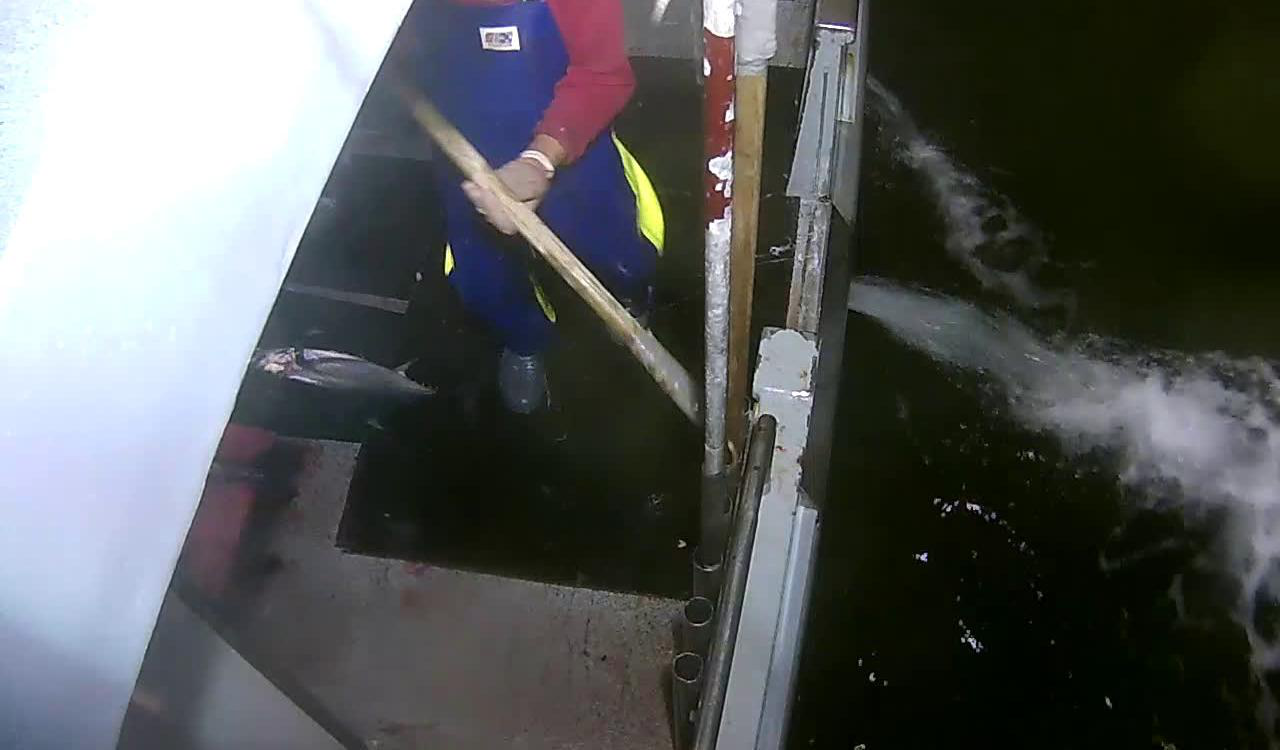

In [343]:
datasets.ImageFolder(os.path.join(path, 'valid'))[1][0]

In [344]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor()
    ]),
}
raw_image_datasets = {x: datasets.ImageFolder(os.path.join(path, x), data_transforms['train']) for x in ['train', 'valid']}

In [410]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i, data_kind):
    bb = val_bbox[i]
    plot(raw_image_datasets[data_kind][i][0])
    plt.gca().add_patch(create_rect(bb))

In [411]:
%matplotlib inline

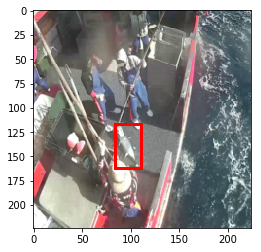

In [412]:
show_bb(0, 'valid')

### Create & train model

- 最後のDense layerを2つ用意し、labelの予測とbounding boxの予測を行う
- loss関数はそれぞれCross EntropyとMean squared error
  - lossは合計値を最小化している
    - モデルによって最小化される損失値は全ての個々の損失の合計になります
      - [Modelクラス](https://keras.io/ja/models/model/)

Kerasでのfitを見るとわかるように、

- trainの入力: conv_feat
- trainの正解: trn_labels, trn_bbox

``` Python
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))
```

備考: データをshuffleしないと全然精度が出なかった

In [413]:
torch.from_numpy(trn_bbox)


  80.2760   66.1290   46.6357   42.1120
  65.8000   14.0647  116.4660  128.5293
  23.6880   26.1555   25.1685  125.0200
                   ⋮                    
  71.3813  130.9000   69.6500  152.9173
  48.0853   52.5000   18.7250  106.3253
  63.7778   66.6750  134.4000   38.2667
[torch.FloatTensor of size 3277x4]

In [414]:
convert_bb(bb_json[raw_filenames[0]], sizes[0])

[80.27600000000123, 66.129000000001, 46.635750000000705, 42.11200000000064]

In [415]:
torch.FloatTensor([convert_bb(bb_json[raw_filenames[0]], sizes[0])])


 80.2760  66.1290  46.6357  42.1120
[torch.FloatTensor of size 1x4]

In [416]:
p=0.6

In [417]:
# dropoutが0.5だと出力がすべてNanになってしまったので、教材通りに変更した
class NetBb(nn.Module):
    def __init__(self):
        super(NetBb, self).__init__()
        self.fc1 = nn.Linear(25088, 512)
        self.fc2 = nn.Linear(512, 512)
        self.bn0 = nn.BatchNorm1d(10)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc_class = nn.Linear(512, 8)
        self.fc_bb = nn.Linear(512, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p/2, training=self.training)
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p, training=self.training)
        x = self.bn2(x)
        x_class = self.fc_class(x)
        x_bb = self.fc_bb(x)
        return x_class, x_bb

In [418]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

In [419]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [430]:
model = NetBb()
if use_gpu:
    model = model.cuda()
criterion_ces = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [431]:
from torch.utils.data import Dataset, DataLoader

class BbDataset(Dataset):
    def __init__(self, image_folder, features, filenames, sizes):
        self.image_folder = image_folder
        self.features = features
        self.filenames = filenames
        self.sizes = sizes

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image, label = self.image_folder.__getitem__(idx)
        bb = torch.FloatTensor([convert_bb(bb_json[self.filenames[idx]], self.sizes[idx])])
        return self.features[idx], label, bb

In [432]:
def train_model(model, criterion_ces, criterion_mse, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels, bbs = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                    bbs = Variable(bbs.cuda())
                else:
                    inputs, labels, bbs = Variable(inputs), Variable(labels), Variable(bbs)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs, outputs_bbs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss_ces = criterion_ces(outputs, labels)
                loss_mse = criterion_mse(outputs_bbs, bbs)
                loss = loss_ces + loss_mse / 1000.0 # 大きさが違いすぎるのでMSEを1000で割る
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] # loss.dataはsize 1 のTensorなので[0]を取る
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            # 最も良いモデルの重みを変数に保持
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [433]:
path = "data/fish/"
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor()
    ]),
}
batch_size = 64 # バッチサイズが大きいとGPUのメモリに乗らないので注意
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x), data_transforms[x])
                  for x in ['train', 'valid']}
bb_datasets = {x: BbDataset(image_datasets[x], conv_feature_map[x], filenames_map[x], sizes_map[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(bb_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(bb_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
print(dataset_sizes, class_names)

{'train': 3277, 'valid': 500} ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [434]:
model_trained = train_model(model, criterion_ces, criterion_mse, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1007 Acc: 0.4077
valid Loss: 0.0928 Acc: 0.5760

Epoch 1/4
----------
train Loss: 0.0918 Acc: 0.5829
valid Loss: 0.0885 Acc: 0.6140

Epoch 2/4
----------
train Loss: 0.0874 Acc: 0.6604
valid Loss: 0.0858 Acc: 0.6640

Epoch 3/4
----------
train Loss: 0.0835 Acc: 0.7348
valid Loss: 0.0839 Acc: 0.7020

Epoch 4/4
----------
train Loss: 0.0795 Acc: 0.7662
valid Loss: 0.0806 Acc: 0.7140

Training complete in 2m 51s
Best val Acc: 0.714000


## Larger size

### Set up data

- 1280x720が一番多そうなので、その縮尺で画像を取る
- finetuneはしないで推論だけしてconv layerの出力を得る
  - まだ情報を落としたくないため、最後のmax poolingも除去する

In [2]:
path = "data/fish/"

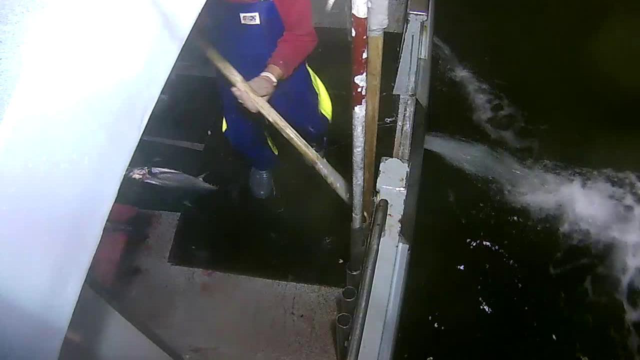

In [3]:
datasets.ImageFolder(os.path.join(path, 'valid'), transforms.Compose([transforms.Resize([360, 640])]))[1][0]

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([360, 640]),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize([360, 640]),
        transforms.ToTensor()
    ]),
}

path = "data/fish/"
batch_size = 12 # バッチサイズが大きいとGPUのメモリに乗らないので注意
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
print(dataset_sizes, class_names)
use_gpu = torch.cuda.is_available()
print(use_gpu)

{'train': 3277, 'valid': 500} ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
True


In [5]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [6]:
vgg16.features[-1]

MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))

In [7]:
modules = list(vgg16.features.children())
modules.pop()
new_features = torch.nn.Sequential(*modules)
new_classifier = torch.nn.Sequential()
vgg16.features = new_features
vgg16.classifier = new_classifier

In [8]:
if use_gpu:
    vgg16 = vgg16.cuda()

In [9]:
batch_size=16

In [10]:
# Shuffleすると、あとで使うときに別途ロードしたデータと一致しなくなってしまう
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=4) for x in ['train', 'valid']}

In [11]:
result_map = {'train': [], 'valid': []}
for phase in ['train', 'valid']:
    vgg16.features.train(False)
    for data in dataloaders[phase]:
        inputs, labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)
        outputs = vgg16.features(inputs)
        result_map[phase].append(outputs.data.cpu())

In [12]:
feature_tensors = {x: torch.cat(result_map[x]) for x in ["train", "valid"]}

In [13]:
for x in ["train", "valid"]:
    torch.save(feature_tensors[x], "conv_features_large_{0}.pt".format(x))

### Fully convolutional net (FCN)

- 以下の理由でFCNを試す
  1. 画像サイズを大きくしたのでDense layerだとパラメーターが多くなりすぎる
  2. 魚は画像中に小さく写っているので、FCNの上手く抽象化するという特徴が活かせる可能性がある

In [2]:
nf = 128

``` python
# target output size of 5x7
m = nn.AdaptiveAvgPool2d((5,7))
input = autograd.Variable(torch.randn(1, 64, 8, 9)) # batch_size x (the number of input planes) x H x W
m(input).size() # 1x64x8x9
```

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_bn1 = nn.BatchNorm2d(512) # argument: num_features (batch_size x num_features x height x width)
        self.conv1 = nn.Conv2d(512, nf, kernel_size=3)
        self.conv_bn2 = nn.BatchNorm2d(nf)
        self.conv2 = nn.Conv2d(nf, nf, kernel_size=3)
        self.conv_bn3 = nn.BatchNorm2d(nf)
        self.conv3 = nn.Conv2d(nf, 8, kernel_size=3)

    def forward(self, x):
        x = self.conv_bn1(x)
        x = F.relu(self.conv1(x))
        x = self.conv_bn2(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.conv_bn2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.adaptive_avg_pool2d(x, 1).squeeze()
        return x

In [24]:
conv_feature_map = {x: torch.load("conv_features_large_{0}.pt".format(x)) for x in ["train", "valid"]}

In [25]:
print(conv_feature_map['train'].size(), conv_feature_map['valid'].size())

torch.Size([3277, 512, 22, 40]) torch.Size([500, 512, 22, 40])


In [26]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [40]:
model = Net()
if use_gpu:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [41]:
model

Net (
  (conv_bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (conv1): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(128, 8, kernel_size=(3, 3), stride=(1, 1))
)

In [42]:
from torch.utils.data import Dataset, DataLoader

class LinearDataset(Dataset):
    def __init__(self, image_folder, features):
        self.image_folder = image_folder
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image, label = self.image_folder.__getitem__(idx)
        return self.features[idx], label

In [43]:
path = "data/fish/"
batch_size = 32 # バッチサイズが大きいとGPUのメモリに乗らないので注意
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x))
                  for x in ['train', 'valid']}
linear_datasets = {x: LinearDataset(image_datasets[x], conv_feature_map[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(linear_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(linear_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
print(dataset_sizes, class_names)

{'train': 3277, 'valid': 500} ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [44]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] # loss.dataはsize 1 のTensorなので[0]を取る
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            # 最も良いモデルの重みを変数に保持
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [45]:
model_trained = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0616 Acc: 0.6085
valid Loss: 0.1140 Acc: 0.2400

Epoch 1/4
----------
train Loss: 0.0777 Acc: 0.3906
valid Loss: 0.0645 Acc: 0.3200

Epoch 2/4
----------
train Loss: 0.0656 Acc: 0.4141
valid Loss: 0.0665 Acc: 0.4120

Epoch 3/4
----------
train Loss: 0.0654 Acc: 0.4397
valid Loss: 0.0665 Acc: 0.4420

Epoch 4/4
----------
train Loss: 0.0653 Acc: 0.4504
valid Loss: 0.0665 Acc: 0.4460

Training complete in 2m 28s
Best val Acc: 0.446000
